## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools_ar
from importlib import reload
from variaIa import stretchevol
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full, z_max
from IPython.display import display, Latex
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
    "axes.labelsize": 'x-large',
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'})
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

## Stretch et color pour SDSS et PS1 overlapping

### Modèle _base_ pour comparaison

In [3]:
gen = stretchevol.generic()
gen.set_model('Evol3G2M2S')
baseTOT = gen.fit(df_nc)

### KS test

In [4]:
df_ncused = df_nc[df_nc['survey'] == 'PS1']
df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                  & (df_ncused['redshifts'] < 0.20)]
x1_ps = df_cmid.stretchs
c_ps = df_cmid.colors

df_ncused = df_nc[df_nc['survey'] == 'SDSS']
df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                  & (df_ncused['redshifts'] < 0.20)]
x1_sdss = df_cmid.stretchs
c_sdss = df_cmid.colors

x1_ks = scipy.stats.ks_2samp(x1_ps, x1_sdss)[1]
c_ks = scipy.stats.ks_2samp(c_ps, c_sdss)[1]

### Tracé des stretchs et colors de survey

Survey: SDSS #SNe: 146
Survey: PS1 #SNe: 52
Survey: SDSS #SNe: 146
Survey: PS1 #SNe: 52


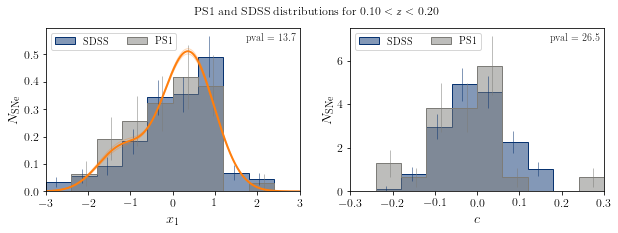

In [6]:
fig = plt.figure(figsize=[10, 3])

prop = dict(marker="o", s=20, lw=1)

for k in range(2):
    ax = fig.add_subplot(int('12' + str(k+1)))
    for i, survey in enumerate(surveys[1:3]):
        df_ncused = df_nc[df_nc['survey'] == survey]
        df_cused = df_c[df_c['survey'] == survey]
        df_clow = df_ncused[(df_ncused['redshifts'] > 0.10)
                          & (df_ncused['redshifts'] < 0.15)]
        df_cup = df_ncused[(df_ncused['redshifts'] > 0.15)
                         & (df_ncused['redshifts'] < 0.20)]
        df_cmid = df_ncused[(df_ncused['redshifts'] > 0.10)
                          & (df_ncused['redshifts'] < 0.20)]
        
        print('Survey:', survey, '#SNe:', len(df_cmid))
        
        toplot = [df_cmid.stretchs, df_cmid.colors]
        torange = [[-3, 3], [-0.3, 0.3]]
        tolabel = [r'$x_1$', r'$c$']
        toname = ['stretch', 'color']
        shift = [[-0.05, 0.05], [-0.005, 0.005]]
        
        prop = {"range":torange[k], "bins":10}
    
        h, r = np.histogram(toplot[k], density=False, **prop)
        
        xbin = np.mean([r[:-1], r[1:]], axis=0)
        xbin = xbin + shift[k][i]
        
        ybin, _ = np.histogram(toplot[k], density=True, **prop)
        
        norm = h[1]/ybin[1]
        yerr = np.sqrt(h)/norm
    
        ax.hist(toplot[k], density=True,
                histtype='step', fill=True, zorder=1,
                edgecolor=colors[survey],
                facecolor=alphacolors(.5, survey),
                label=survey, **prop)
        
        ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                    marker="None", ls="None",
                    lw=1, alpha=.5,
                    ecolor=colors[survey])
        
    if k == 1:
        ax.text(0.97*torange[k][-1], 0.97*ax.get_ylim()[-1],
                'pval = ' + '%.1f%%'%(c_ks*100),
                horizontalalignment='right',
                verticalalignment='top',
                alpha=.8)
    
    else:
        ax.text(0.97*torange[k][-1], 0.97*ax.get_ylim()[-1],
                'pval = ' + '%.1f%%'%(x1_ks*100),
                horizontalalignment='right',
                verticalalignment='top',
                alpha=.8)
    
        x_lin = np.linspace(-3, 3, 1000)
        pdfmodel_low = baseTOT.likelihood_tot(baseTOT.delta(0.10),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.15),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_upp = baseTOT.likelihood_tot(baseTOT.delta(0.20),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
        ax.plot(x_lin, pdfmodel_low, **baseprop)
        ax.plot(x_lin, pdfmodel_mid, lw=2, color='C1')
        ax.plot(x_lin, pdfmodel_upp, **baseprop)
        
    ax.tick_params(labelsize=12)

    ax.set_xlabel(tolabel[k], fontsize = 'x-large')
    ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

    ax.set_xlim(torange[k][0], torange[k][-1])

    ax.legend(loc='upper left', fontsize='medium', ncol=5)
    plt.suptitle(r'PS1 and SDSS distributions for $0.10 < z < 0.20$')

path = '../../Images/pdf/both-cut'
#path = path + '_SDSS_PS1-010-015.pdf'
#path = path + '_SDSS_PS1-015-020.pdf'
path = path + '_SDSS_PS1-010-020.pdf'
#fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/both-cut'
#path = path + '_SDSS_PS1-010-015.png'
#path = path + '_SDSS_PS1-015-020.png'
path = path + '_SDSS_PS1-010-020.png'
#fig.savefig(path, bbox_inches='tight', dpi=600)

## Same for PS1 and SNLS

### KS test

In [8]:
df_ncused = df_nc[df_nc['survey'] == 'PS1']
df_cut = df_ncused[(df_ncused['redshifts'] > 0.20)
                 & (df_ncused['redshifts'] <= z_max['PS1'][-1])]
df_cutop = df_ncused[(df_ncused['redshifts'] > 0.20)
                   & (df_ncused['redshifts'] <= 0.35)]
df_cutsup = df_ncused[(df_ncused['redshifts'] > 0.20)
                    & (df_ncused['redshifts'] <= 0.40)]
x1_ps_2 = df_cut.stretchs
c_ps_2 = df_cut.colors
x1_ps_3 = df_cutop.stretchs
c_ps_3 = df_cutop.colors
x1_ps_4 = df_cutsup.stretchs
c_ps_4 = df_cutsup.colors

df_ncused = df_nc[df_nc['survey'] == 'SNLS']
df_cut = df_ncused[(df_ncused['redshifts'] > 0.20)
                 & (df_ncused['redshifts'] <= z_max['PS1'][-1])]
df_cutop = df_ncused[(df_ncused['redshifts'] > 0.20)
                   & (df_ncused['redshifts'] <= 0.35)]
df_cutsup = df_ncused[(df_ncused['redshifts'] > 0.20)
                    & (df_ncused['redshifts'] <= 0.40)]
x1_snls_2 = df_cut.stretchs
c_snls_2 = df_cut.colors
x1_snls_3 = df_cutop.stretchs
c_snls_3 = df_cutop.colors
x1_snls_4 = df_cutsup.stretchs
c_snls_4 = df_cutsup.colors

x1_ks_2 = scipy.stats.ks_2samp(x1_ps_2, x1_snls_2)[1]
c_ks_2 = scipy.stats.ks_2samp(c_ps_2, c_snls_2)[1]
x1_ks_3 = scipy.stats.ks_2samp(x1_ps_3, x1_snls_3)[1]
c_ks_3 = scipy.stats.ks_2samp(c_ps_3, c_snls_3)[1]
x1_ks_4 = scipy.stats.ks_2samp(x1_ps_4, x1_snls_4)[1]
c_ks_4 = scipy.stats.ks_2samp(c_ps_4, c_snls_4)[1]

## Plot

Survey: PS1 #SNe: 90
Survey: SNLS #SNe: 31
Survey: PS1 #SNe: 90
Survey: SNLS #SNe: 31


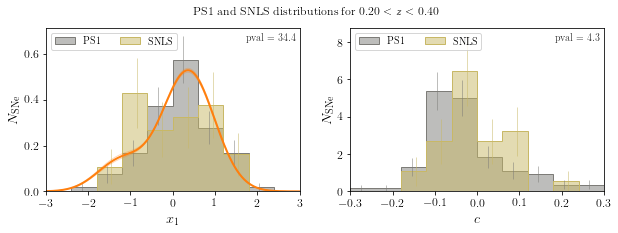

In [9]:
fig = plt.figure(figsize=[10, 3])

prop = dict(marker="o", s=20, lw=1)

for k in range(2):
    ax = fig.add_subplot(int('12' + str(k+1)))
    for i, survey in enumerate(['PS1', 'SNLS']):
        df_ncused = df_nc[df_nc['survey'] == survey]
        df_cused = df_c[df_c['survey'] == survey]
        df_cut = df_ncused[(df_ncused['redshifts'] > 0.20)
                         & (df_ncused['redshifts'] <= z_max['PS1'][-1])]
        df_cutop = df_ncused[(df_ncused['redshifts'] > 0.20)
                           & (df_ncused['redshifts'] <= 0.35)]
        df_cutsup = df_ncused[(df_ncused['redshifts'] > 0.20)
                            & (df_ncused['redshifts'] <= 0.40)]
        
        print('Survey:', survey, '#SNe:', len(df_cutsup))
        
        toplot = [df_cutsup.stretchs, df_cutsup.colors]
        torange = [[-3, 3], [-0.3, 0.3]]
        tolabel = [r'$x_1$', r'$c$']
        toname = ['stretch', 'color']
        shift = [[-0.05, 0.05], [-0.005, 0.005]]
        
        prop = {"range":torange[k], "bins":10}
    
        h, r = np.histogram(toplot[k], density=False, **prop)
        
        xbin = np.mean([r[:-1], r[1:]], axis=0)
        xbin = xbin + shift[k][i]
        
        ybin, _ = np.histogram(toplot[k], density=True, **prop)
        
        norm = h[2]/ybin[2]
        yerr = np.sqrt(h)/norm
    
        ax.hist(toplot[k], density=True,
                histtype='step', fill=True, zorder=1,
                edgecolor=colors[survey],
                facecolor=alphacolors(.5, survey),
                label=survey, **prop)
        
        ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                    marker="None", ls="None",
                    lw=1, alpha=.5,
                    ecolor=colors[survey])
        
    if k == 1:
        ax.text(0.97*torange[k][-1], 0.97*ax.get_ylim()[-1],
                #'pval = ' + '%.1f%%'%(c_ks_2*100),
                #'pval = ' + '%.1f%%'%(c_ks_3*100),
                'pval = ' + '%.1f%%'%(c_ks_4*100),
                horizontalalignment='right',
                verticalalignment='top',
                alpha=.8)
    
    else:
        ax.text(0.97*torange[k][-1], 0.97*ax.get_ylim()[-1],
                #'pval = ' + '%.1f%%'%(x1_ks_2*100),
                #'pval = ' + '%.1f%%'%(x1_ks_3*100),
                'pval = ' + '%.1f%%'%(x1_ks_4*100),
                horizontalalignment='right',
                verticalalignment='top',
                alpha=.8)
    
        x_lin = np.linspace(-3, 3, 1000)
        pdfmodel_low = baseTOT.likelihood_tot(baseTOT.delta(0.20),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.25),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_upp = baseTOT.likelihood_tot(baseTOT.delta(0.30),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
        ax.plot(x_lin, pdfmodel_low, **baseprop)
        ax.plot(x_lin, pdfmodel_mid, lw=2, color='C1')
        ax.plot(x_lin, pdfmodel_upp, **baseprop)
        
    ax.tick_params(labelsize=12)

    ax.set_xlabel(tolabel[k], fontsize = 'x-large')
    ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

    ax.set_xlim(torange[k][0], torange[k][-1])

    ax.legend(loc='upper left', fontsize='medium', ncol=5)
    #plt.suptitle('PS1 and SNLS distributions for 0.20 < z < 0.30')
    #plt.suptitle('PS1 and SNLS distributions for 0.20 < z < 0.35')
    plt.suptitle('PS1 and SNLS distributions for $0.20 < z < 0.40$')

path = '../../Images/pdf/both-cut'
#path = path + '_SNLS_PS1-020-030.pdf'
#path = path + '_SNLS_PS1-020-035.pdf'
path = path + '_SNLS_PS1-020-040.pdf'
#fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/both-cut'
#path = path + '_SNLS_PS1-020-030.png'
#path = path + '_SNLS_PS1-020-035.png'
path = path + '_SNLS_PS1-020-040.png'
#fig.savefig(path, bbox_inches='tight', dpi=600)

## Combination of both

## Plot

Survey: SDSS #SNe: 146
Survey: PS1 #SNe: 52
Survey: PS1 #SNe: 90
Survey: SNLS #SNe: 12
Survey: SDSS #SNe: 146
Survey: PS1 #SNe: 52
Survey: PS1 #SNe: 90
Survey: SNLS #SNe: 12


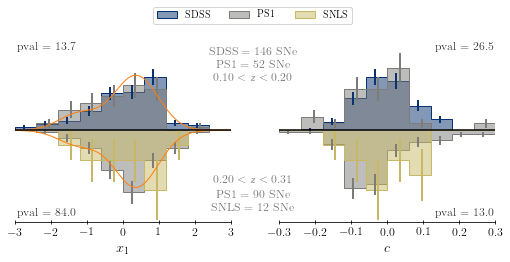

In [10]:
fact = 0.75
fig = plt.figure(figsize=[fact*10, fact*4])

prop = dict(marker="o", s=20, lw=1)

# for horiz
left, width = 0.12, 0.40
bottom, height = 0.11, 0.85
xspan = 0.09

for k in range(2):
    ax = fig.add_axes([left+k*(width+xspan), bottom, width, height])
    for i, survey in enumerate(['SDSS', 'PS1', 'PS1', 'SNLS']):
        df_ncused = df_nc[df_nc['survey'] == survey]
        df_cused = df_c[df_c['survey'] == survey]
        
        if i < 2:
            df_cutsup = df_ncused[(df_ncused['redshifts'] > 0.10)
                                & (df_ncused['redshifts'] <= 0.20)]
        else:
            df_cutsup = df_ncused[(df_ncused['redshifts'] > 0.20)
                                & (df_ncused['redshifts'] <= z_max['PS1'][-1])]
        
        print('Survey:', survey, '#SNe:', len(df_cutsup))
        
        toplot = [df_cutsup.stretchs, df_cutsup.colors]
        torange = [[-3, 3], [-0.3, 0.3]]
        torange_y = [[-0.85, 0.85], [-8.5, 8.5]]
        tolabel = [r'$x_1$', r'$c$']
        tolabelsurv = ['SDSS', 'PS1', '', 'SNLS']
        w = [1, 1, -1, -1]
        valpos = [0.92, 0.86, 0.21, 0.15]
        valali = ['top', 'top', 'bottom', 'bottom']
        toname = ['stretch', 'color']
        shift = [[-0.05, 0.05], [-0.005, 0.005],
                 [-0.05, 0.05], [-0.005, 0.005]]
        
        prop = {"range":torange[k], "bins":10}
        prop_txt = {'alpha': 0.8, 'fontsize': 'large'}
        prop_txt_mid = {'alpha': 0.8, 'fontsize': 'large', 'color': '0.3'}
    
        h, r = np.histogram(toplot[k], density=False, **prop)
        
        xbin = np.mean([r[:-1], r[1:]], axis=0)
        xbin = xbin + shift[k][i%2]
        
        ybin, _ = np.histogram(toplot[k], density=True, **prop)
        
        norm = h[3]/ybin[3]
        yerr = np.sqrt(h)/norm
        
        if k == 0:
            ax.hist(toplot[k], weights=[w[i]*1/norm for j in range(len(toplot[k]))],
                    histtype='step', fill=True, zorder=1,
                    edgecolor=colors[survey],
                    facecolor=alphacolors(.5, survey),
                    label=tolabelsurv[i], **prop)
            
            ax.errorbar(xbin, w[i]*ybin, yerr=np.sqrt(h)/norm,
                        marker="None", ls="None",
                        lw=2, alpha=1,
                        ecolor=colors[survey])
             
            fig.text(0.56, valpos[i],
                     f'{survey} = {len(df_cutsup)} SNe',
                     horizontalalignment='center',
                     verticalalignment=valali[i],
                     **prop_txt_mid)
                
        else:
            ax.hist(toplot[k], weights=[w[i]*1/norm for j in range(len(toplot[k]))],
                    histtype='step', fill=True, zorder=1,
                    edgecolor=colors[survey],
                    facecolor=alphacolors(.5, survey),
                    label=tolabelsurv[i], **prop)
            
            ax.errorbar(xbin, w[i]*ybin, yerr=np.sqrt(h)/norm,
                        marker="None", ls="None",
                        lw=2, alpha=1,
                        ecolor=colors[survey])
       
    if k == 1:
        ax.text(0.99, 0.98,
                'pval = ' + '%.1f%%'%(c_ks*100),
                horizontalalignment='right',
                verticalalignment='top',
                **prop_txt,
                transform=ax.transAxes)
        
        ax.text(0.99, 0.02,
                'pval = ' + '%.1f%%'%(c_ks_2*100),
                horizontalalignment='right',
                verticalalignment='bottom',
                **prop_txt,
                transform=ax.transAxes)

        fig.text(0.56, 0.80,
                 r'$0.10 < z < 0.20$',
                 horizontalalignment='center',
                 verticalalignment='top',
                 **prop_txt_mid)
        
        fig.text(0.56, 0.28,
                 r'$0.20 < z < 0.31$',
                 horizontalalignment='center',
                 verticalalignment='bottom',
                 **prop_txt_mid)
        
    else:
        ax.text(0.01, 0.98,
                'pval = ' + '%.1f%%'%(x1_ks*100),
                horizontalalignment='left',
                verticalalignment='top',
                **prop_txt,
                transform=ax.transAxes)
        
        ax.text(0.01, 0.02,
                'pval = ' + '%.1f%%'%(x1_ks_2*100),
                horizontalalignment='left',
                verticalalignment='bottom',
                **prop_txt,
                transform=ax.transAxes)

    if k != 1:
        x_lin = np.linspace(-3, 3, 1000)
        pdfmodel_low = baseTOT.likelihood_tot(baseTOT.delta(0.10),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.15),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_upp = baseTOT.likelihood_tot(baseTOT.delta(0.20),
                                              x_lin, 0, #np.mean(dx1),
                                              baseTOT.param['aa'],
                                              baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                              baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
        #ax.plot(x_lin, pdfmodel_low, **baseprop)
        ax.plot(x_lin, pdfmodel_mid, lw=1, color='C1')
        #ax.plot(x_lin, pdfmodel_upp, **baseprop)
        
        pdfmodel_low = -baseTOT.likelihood_tot(baseTOT.delta(0.20),
                                               x_lin, 0, #np.mean(dx1),
                                               baseTOT.param['aa'],
                                               baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                               baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_mid = -baseTOT.likelihood_tot(baseTOT.delta(0.25),
                                               x_lin, 0, #np.mean(dx1),
                                               baseTOT.param['aa'],
                                               baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                               baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        pdfmodel_upp = -baseTOT.likelihood_tot(baseTOT.delta(0.30),
                                               x_lin, 0, #np.mean(dx1),
                                               baseTOT.param['aa'],
                                               baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                               baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
        #ax.plot(x_lin, pdfmodel_low, **baseprop)
        ax.plot(x_lin, pdfmodel_mid, lw=1, color='C1')
        #ax.plot(x_lin, pdfmodel_upp, **baseprop)
        
    ax.tick_params(labelsize=12, axis='x', direction='inout')

    ax.set_xlabel(tolabel[k], fontsize='x-large')

    ax.set_yticks([])

    ax.set_xlim(torange[k][0], torange[k][-1])
    ax.set_ylim(torange_y[k][0], torange_y[k][-1])
    if k == 0:
        ax.legend(loc='upper center', fontsize='medium', ncol=5,
                  #bbox_to_anchor=(1.0, 1.0, 0.20, 0.17))
                  bbox_to_anchor=(1.0, 1.0, 0.20, 0.20))
        
    clearwhich = ["left", "right", "top"]
    [ax.spines[which].set_visible(False) for which in clearwhich]
    
    ax.axhline(y=0, lw=1.5, color='k')
    #plt.suptitle('PS1 and SDSS between 0.10 < z < 0.20, PS1 and SNLS between 0.20 < z < 0.40')

path = '../../../Images/pdf/both-cut'
#path = path + '_SNLS_PS1-020-030.pdf'
#path = path + '_SNLS_PS1-020-035.pdf'
path = path + '_SDSS_SNLS_PS1.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/both-cut'
##path = path + '_SNLS_PS1-020-030.png'
##path = path + '_SNLS_PS1-020-035.png'
path = path + '_SDSS_SNLS_PS1.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Same for SNf, PS1 and SDSS

### KS test

In [64]:
zrange = [0.05, 0.10]

df_ncused = df_three[df_three['survey'] == 'SNF']
df_cut = df_ncused[(df_ncused['redshifts'] > zrange[0])
                 & (df_ncused['redshifts'] <= zrange[1])]

x1_snf = df_cut.stretchs
c_snf = df_cut.colors

df_ncused = df_three[df_three['survey'] == 'SDSSPS1']
df_cut = df_ncused[(df_ncused['redshifts'] > zrange[0])
                 & (df_ncused['redshifts'] <= zrange[1])]
x1_sdssps = df_cut.stretchs
c_sdssps = df_cut.colors

x1_ks_5 = scipy.stats.ks_2samp(x1_snf, x1_sdssps)[1]
c_ks_5 = scipy.stats.ks_2samp(c_snf, c_sdssps)[1]

## Plot

In [89]:
for survey in ['SNF', 'SDSS', 'PS1']:
    print(np.min(df_nc[df_nc['survey'] == survey]['redshifts']),
          np.max(df_nc[df_nc['survey'] == survey]['redshifts']))

0.02264582581638153 0.07883286325413175
0.03652 0.19867
0.0264 0.3092


In [22]:
df_comb = df[df['survey'].isin(['PS1', 'SDSS'])]
df_comb['survey'] = 'SDSSPS1'

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_three = pd.concat([df_comb, df[df['survey'] == 'SNF']])

Survey: SNF #SNe: 69
Survey: SDSSPS1 #SNe: 34
Survey: SNF #SNe: 69
Survey: SDSSPS1 #SNe: 34


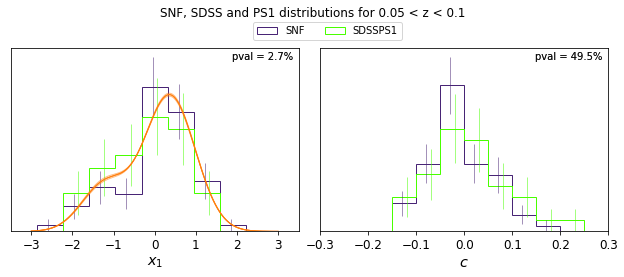

In [93]:
fig = plt.figure(figsize=[10, 3])

smap = plt.cm.get_cmap('viridis')
colors = {'SNF': smap(0.1),
          'SDSS': smap(0.3),
          'SDSSPS1': plt.cm.get_cmap('hsv')(0.29),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99)}# for cividis
          #'HST': smap(300)}# for viridis
surveys = colors.keys()
    
alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

zrange = [0.05, 0.10]

# for horiz
left, width = 0.12, 0.40
bottom, height = 0.11, 0.85
xspan = 0.03

for k in range(2):
    ax = fig.add_axes([left+k*(width+xspan), bottom, width, height])
    for i, survey in enumerate(['SNF', 'SDSSPS1']):
        df_ncused = df_three[df_three['survey'] == survey]
        df_cut = df_ncused[(df_ncused['redshifts'] > zrange[0])
                         & (df_ncused['redshifts'] <= zrange[1])]
       
        print('Survey:', survey, '#SNe:', len(df_cut))
        
        toplot = [df_cut.stretchs, df_cut.colors]
        torange = [[-3.5, 3.5], [-0.3, 0.3]]
        tolabel = [r'$x_1$', r'$c$']
        toname = ['stretch', 'color']
        shift = [[-0.05, 0.05], [-0.005, 0.005]]
        tobins = [11, 12]
        
        prop = {"range": torange[k], "bins": tobins[k]}
        
        h, r = np.histogram(toplot[k], density=False, **prop)
        
        xbin = np.mean([r[:-1], r[1:]], axis=0)
        xbin = xbin + shift[k][i]
        
        ybin, _ = np.histogram(toplot[k], density=True, **prop)
        
        norm = h[3]/ybin[3]
        yerr = np.sqrt(h)/norm
        
        if k == 0:
            ax.hist(toplot[k], density=True,
                    histtype='step',# fill=True,
                    zorder=1,
                    edgecolor=colors[survey],
                    facecolor=alpha5colors[survey],
                    label=survey, **prop)
            
            ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                        marker="None", ls="None",
                        lw=1, alpha=.5,
                        ecolor=colors[survey])
        
        else:
            ax.hist(toplot[k], density=True,
                    histtype='step',# fill=True,
                    zorder=1,
                    edgecolor=colors[survey],
                    facecolor=alpha5colors[survey],
                    **prop)
            
            ax.errorbar(xbin, ybin, yerr=np.sqrt(h)/norm,
                        marker="None", ls="None",
                        lw=1, alpha=.5,
                        ecolor=colors[survey])            
            
        if k == 1:
            ax.text(0.98, 0.98,
                    'pval = ' + '%.1f%%'%(c_ks_5*100),
                    horizontalalignment='right',
                    verticalalignment='top',
                    alpha=.8, transform=ax.transAxes)
        
        else:
            ax.text(0.98, 0.98,
                    'pval = ' + '%.1f%%'%(x1_ks_5*100),
                    horizontalalignment='right',
                    verticalalignment='top',
                    alpha=.8, transform=ax.transAxes)
        
        if k != 1:
            x_lin = np.linspace(-3, 3, 1000)
            pdfmodel_low = baseTOT.likelihood_tot(baseTOT.delta(0.05),
                                                  x_lin, 0, #np.mean(dx1),
                                                  baseTOT.param['aa'],
                                                  baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                                  baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
            pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.075),
                                                  x_lin, 0, #np.mean(dx1),
                                                  baseTOT.param['aa'],
                                                  baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                                  baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
            pdfmodel_upp = baseTOT.likelihood_tot(baseTOT.delta(0.10),
                                                  x_lin, 0, #np.mean(dx1),
                                                  baseTOT.param['aa'],
                                                  baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                                  baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
            baseprop = {'lw': 1, 'alpha': 0.3, 'color': 'C1'}
            ax.plot(x_lin, pdfmodel_low, **baseprop)
            ax.plot(x_lin, pdfmodel_mid, lw=1, color='C1')
            ax.plot(x_lin, pdfmodel_upp, **baseprop)
        
    ax.tick_params(labelsize=12)

    ax.set_xlabel(tolabel[k], fontsize = 'x-large')

    ax.set_yticks([])
    ax.set_xlim(torange[k][0], torange[k][-1])

    if k == 0:
        ax.legend(loc='upper center', fontsize='medium', ncol=5,
                  bbox_to_anchor=(1.0, 1.0, 0.20, 0.17))
    plt.suptitle(f'SNF, SDSS and PS1 distributions for {zrange[0]} < z < {zrange[1]}', y=1.15, x=0.54)

path = '../../Images/pdf/both-cut'
path = path + '_SNF_SDSS_PS1-004-010.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/both-cut'
path = path + '_SNF_SDSS_PS1-004-010.png'
fig.savefig(path, bbox_inches='tight', dpi=600)